In [177]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_table('data/playlist_summary_external.txt')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403366 entries, 0 to 403365
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   playlist_uri             403366 non-null  object
 1   owner                    403366 non-null  object
 2   streams                  403366 non-null  int64 
 3   stream30s                403366 non-null  int64 
 4   dau                      403366 non-null  int64 
 5   wau                      403366 non-null  int64 
 6   mau                      403366 non-null  int64 
 7   mau_previous_month       403366 non-null  int64 
 8   mau_both_months          403366 non-null  int64 
 9   users                    403366 non-null  int64 
 10  skippers                 403366 non-null  int64 
 11  owner_country            403366 non-null  object
 12  n_tracks                 403366 non-null  int64 
 13  n_local_tracks           403366 non-null  int64 
 14  n_artists           

In [4]:
data.describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s
count,4.033660e+05,4.033660e+05,403366.000000,403366.000000,4.033660e+05,4.033660e+05,403366.000000,4.033660e+05,403366.000000,403366.000000,403366.000000,403366.000000,403366.000000,4.033660e+05,403366.000000
mean,7.101375e+01,4.283333e+01,4.418265,21.784446,6.614290e+01,5.819009e+01,12.937065,1.493085e+02,2.827749,201.483432,3.084035,83.852050,88.224250,1.260489e+03,93.556621
std,6.492014e+03,3.772412e+03,358.855685,1614.650805,4.732580e+03,3.827248e+03,1240.912979,9.247484e+03,205.059728,584.077765,40.330266,128.152488,133.193118,1.062463e+05,226.250189
min,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000,2.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,1.000000e+00,1.000000,2.000000e+00,0.000000,38.000000,0.000000,18.000000,19.000000,3.100000e+01,6.000000
50%,1.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,2.000000e+00,1.000000,3.000000e+00,0.000000,84.000000,0.000000,46.000000,48.000000,7.900000e+01,30.000000
75%,8.000000e+00,5.000000e+00,1.000000,2.000000,4.000000e+00,3.000000e+00,2.000000,7.000000e+00,0.000000,192.000000,0.000000,100.000000,106.000000,1.930000e+02,96.000000
max,2.629715e+06,1.513237e+06,152929.000000,669966.000000,1.944150e+06,1.478684e+06,578391.000000,3.455406e+06,86162.000000,79984.000000,9117.000000,5226.000000,6397.000000,4.249733e+07,25904.000000


In [5]:
data.nunique()

playlist_uri               403366
owner                      314899
streams                      1639
stream30s                    1329
dau                           566
wau                          1019
mau                          1597
mau_previous_month           1552
mau_both_months               765
users                        2293
skippers                      522
owner_country                   1
n_tracks                     4134
n_local_tracks                576
n_artists                    1560
n_albums                     1621
monthly_stream30s            6094
monthly_owner_stream30s      2418
tokens                     192107
genre_1                        26
genre_2                        26
genre_3                        26
mood_1                         27
mood_2                         27
mood_3                         27
dtype: int64

Quick summary of data:  There are no missing values for any of the columns.  Each row is uniquely indexed by playlist_uri.  There are 26 distinct values of the genre variables and 27 distinct values of the mood variables.  There is only one distinct value of owner_country, so we will drop it here.  We should then mention that this analysis only applies to US-created playlists and may or may not generalize to other country's playlists.

Of the 403,366 unique playlists, there are 314,899 distinct playlists and thus most owners in this dataset only have one playlist included.  Let's explore the distribution of the number of playlists each owner has.

In [6]:
data = data.drop(columns = 'owner_country')

In [53]:
data.tokens.head(30)

0     ["ambient", "music", "therapy", "binaural", "b...
1                                    ["good", "living"]
2                                      ["norte\u00f1a"]
3                                                    []
4                                   ["cheesy", "pants"]
5                                      ["aids", "walk"]
6                                            ["classy"]
7                                    ["iranian", "rap"]
8                                               ["fly"]
9                                  ["reading", "music"]
10                                    ["mac", "miller"]
11                                                   []
12                                              ["rap"]
13                                                   []
14                                    ["sunny", "daze"]
15                                       ["croatiaaaa"]
16                                 ["gangsta", "party"]
17                             ["chiraq", "drill

In [54]:
data.tokens[0]

'["ambient", "music", "therapy", "binaural", "beats", "ambient", "clear", "binaural", "beats"]'

In [47]:
owner_playlist_counts = (data.
                        groupby('owner').
                        size().
                        reset_index().
                        rename(columns = {0: 'n_playlists'}).
                        query('n_playlists > 1').
                        sort_values('n_playlists', ascending = False)
                        )

Of the 314,899 unique playlist owners, 261,040 (83%) have exactly one playlist in the data.  There are 399 playlists in which the owner is 'spotify'.  The most playlists by an individual user is 48.  The individual with the 30th most playlists had 21 playlists. 

In [51]:
owner_playlist_counts.head(31)

,owner,n_playlists
314898,spotify,399
129897,6987037f34b5cee787a1a5e8de9b2689,48
203611,a5add6d0d5fbebb01abb2fbe7e47208d,47
301721,f54f32d1c706754a70f8392aa1dbad46,44
91405,4a03268bef1505a49f8b3eced879f311,43
29547,17d6159195b25d619e0eff98f809c90e,40
196624,9ff1b837bb1262d44f2194549748385a,40
5464,0467e18af314d5c84e3e92f196fb05b9,40
47656,2682cc9acee40aa2d9098555fd0f2671,37
300043,f3ef29545d1de52e8c1c0062378826e0,34


<AxesSubplot:>

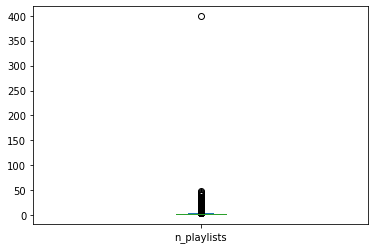

In [45]:
owner_playlist_counts.plot.box()

Let's now try to get an understanding of some of the metrics that could conceivably define a successful playlist.

Classification of Variables:

ID variables:
1. playlist_uri -- The key or index of the playlist, each row has unique value of this
2.  owner -- playlist owner, most but not all owners only have one playlist

Thoughts on what could constitute success:
1. stream30s - Important: this variable only relates to number of streams TODAY
2. dau - Number of users with a 30 SECOND stream TODAY 
3. wau - Number of users with a 30 SECOND stream in the past WEEK
4. mau - Number of users with a 30 SECOND stream in past MONTH
5. mau_previous_month - Number of users with a 30 SECOND stream in month PRIOR to given month
6. mau_both_months - Number of users that were active THIS month and PRIOR month
7. users - Number of users with at least one stream of any time duration (including skips) in past MONTH
8. monthly_stream30s - Number of streams over 30 seconds this month
9. streams - Number of streams from playlist today (Presumably could be any length)
10.  monthly_owner_stream30s - number of streams over 30 seconds by PLAYLIST OWNER this month

WEIRD/USELESS VARIABLES:
1. skippers - This could be inverse coded as a way of measuring playlist success, however THIS IS A CONFUSING VARIABLE. Number of users who skipped more than 90% of their total Spotify streams today and also used this playlist.  Important note: the way this definition reads, a playlist could be 'punished' for simply having users who skip a lot.  It could be that these skippers are not actually skipping the songs in the given playlist.
2.  tokens -- could be a useful variable, but will be hard to parse. 
3. owner_country - could have been interesting, but dataset is only composed of US playlist owners.

PREDICTORS:
1. n_tracks - number of tracks in playlist
2. n_local_tracks - number of tracks that are new from yesterday to today
3. n_artists - number of unique artists in playlist
4. n_albums - number of unique albums in playlist
5-7: genre_1, genre_2, genre_3: genre by weight of playlist tracks, from Gracenote metadata
8_10: mood_1, mood_2, mood_3: mood by weight of playlist tracks, from Gracenote metadata

In [58]:
outcomes = (data.
           set_index('playlist_uri').
           loc[:, ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users',
                  'monthly_stream30s', 'monthly_owner_stream30s']])

In [59]:
outcomes.head()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,monthly_stream30s,monthly_owner_stream30s
playlist_uri,,,,,,,,,,
spotify:user:36069af6af076ccd9e597184a67b68c9:playlist:5M8emOIVn1s6pfibDdCYEu,27,27,1,1,3,3,0,8,30,27
spotify:user:d1144a65b1c31c5f9f56b94f831124d5:playlist:4Xh16WSy5xT1dqai8bDByk,0,0,0,1,2,1,1,3,112,94
spotify:user:6b7fbed9edd6418ddd3b555bba441536:playlist:6zpLN2wRu8z7fo4q6ouaAh,4,2,1,1,7,5,0,15,63,0
spotify:user:580b98725077a94c3c8d01d07390426b:playlist:53GaVDhtrx0FQnh5heSLmN,12,12,1,1,4,6,1,10,154,108
spotify:user:1305d39070c95d161cc502e15014897d:playlist:7ptqVBACAesTGKzKoB88qe,20,4,1,1,2,1,1,2,230,0


It is interesting to note here that there appears to be very high correlation between each of the outcome variables that I have considered as good outcome variables except for the monthly_owner_stream_30s, which is the number of streams over 30 seconds by the playlist owner this month.  This very weak correlation for monthly_owner_stream30s suggests to me that it likely it should not be considered a good measure of a successful playlist. 

In [61]:
outcomes.corr()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,monthly_stream30s,monthly_owner_stream30s
streams,1.000000,0.994380,0.988381,0.967860,0.958000,0.905523,0.957998,0.911023,0.984383,-0.001338
stream30s,0.994380,1.000000,0.985062,0.968307,0.957810,0.908967,0.956223,0.912391,0.992060,-0.000767
dau,0.988381,0.985062,1.000000,0.986290,0.981306,0.938572,0.975665,0.946317,0.980044,-0.003330
wau,0.967860,0.968307,0.986290,1.000000,0.995568,0.957752,0.974101,0.970788,0.978300,-0.004150
mau,0.958000,0.957810,0.981306,0.995568,1.000000,0.969613,0.969983,0.983961,0.970658,-0.004432
mau_previous_month,0.905523,0.908967,0.938572,0.957752,0.969613,1.000000,0.954992,0.990228,0.931162,-0.004802
mau_both_months,0.957998,0.956223,0.975665,0.974101,0.969983,0.954992,1.000000,0.942426,0.971727,-0.003219
users,0.911023,0.912391,0.946317,0.970788,0.983961,0.990228,0.942426,1.000000,0.931219,-0.005115
monthly_stream30s,0.984383,0.992060,0.980044,0.978300,0.970658,0.931162,0.971727,0.931219,1.000000,-0.000519
monthly_owner_stream30s,-0.001338,-0.000767,-0.003330,-0.004150,-0.004432,-0.004802,-0.003219,-0.005115,-0.000519,1.000000


In [65]:
outcomes = outcomes.drop(columns = 'monthly_owner_stream30s')

In [70]:
outcomes.corr()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,monthly_stream30s
streams,1.000000,0.994380,0.988381,0.967860,0.958000,0.905523,0.957998,0.911023,0.984383
stream30s,0.994380,1.000000,0.985062,0.968307,0.957810,0.908967,0.956223,0.912391,0.992060
dau,0.988381,0.985062,1.000000,0.986290,0.981306,0.938572,0.975665,0.946317,0.980044
wau,0.967860,0.968307,0.986290,1.000000,0.995568,0.957752,0.974101,0.970788,0.978300
mau,0.958000,0.957810,0.981306,0.995568,1.000000,0.969613,0.969983,0.983961,0.970658
mau_previous_month,0.905523,0.908967,0.938572,0.957752,0.969613,1.000000,0.954992,0.990228,0.931162
mau_both_months,0.957998,0.956223,0.975665,0.974101,0.969983,0.954992,1.000000,0.942426,0.971727
users,0.911023,0.912391,0.946317,0.970788,0.983961,0.990228,0.942426,1.000000,0.931219
monthly_stream30s,0.984383,0.992060,0.980044,0.978300,0.970658,0.931162,0.971727,0.931219,1.000000


It is interesting to note that the good outcome variables all have pairwise correlations of 0.90 or greater, thus signifying that there is considerable agreement amongst these variables.  
Idea: we may eventually want to create some type of PCA of these variables, where we take the first few PCA components and use those as outcome variables.  

In [164]:
outcomes_scaled = preprocessing.scale(outcomes)
#pca = decomposition.PCA(n_components = 'mle')
pca = decomposition.PCA(n_components = 1)
pca.fit(outcomes_scaled)
outcomes_pca = pca.transform(outcomes_scaled)

In [165]:
outcomes_scaled_df = pd.DataFrame(outcomes_scaled)

There appear to be a couple playlists that are major outliers in terms of how good they look in terms of the outcomes.  They have id 163726 and 152032.  They are off the charts good, being 250-400 standard deviations above the mean of each outcome. 

In [166]:
outcomes_scaled_df.sort_values(0, ascending = False).head()

,0,1,2,3,4,5,6,7,8
163726,405.058792,401.121606,339.971576,318.710307,307.027583,253.667384,293.435173,264.800117,383.270738
152032,389.248578,387.360368,426.145600,414.916367,410.787813,386.342251,466.091329,373.643375,399.977497
216752,113.248512,92.341075,121.200910,136.125710,145.572538,95.606622,88.382667,133.420537,92.972211
23223,104.492050,98.067657,92.584914,68.790325,51.053579,60.269439,112.398080,40.030258,80.787140
309410,89.224658,70.398059,78.857931,74.135140,71.719499,111.824823,92.307202,88.328646,71.586149


In [167]:
pca.explained_variance_ratio_

array([0.96672895])

In [168]:
pca.components_

array([[0.33212089, 0.33241164, 0.3364763 , 0.33712652, 0.33664911,
        0.32777328, 0.33344716, 0.3289958 , 0.3348648 ]])

In [170]:
outcomes_pca_df = pd.DataFrame(outcomes_pca)
outcomes_pca_df = outcomes_pca_df.rename(columns = {0: 'pca_outcome'})

In [172]:
outcomes_pca_df.sort_values('pca_outcome', ascending = False).head()

,pca_outcome
152032,1218.514219
163726,989.517136
216752,339.823294
309410,249.169757
401060,237.095760


In [139]:
biggest = outcomes_scaled_df.iloc[[152032], :]

In [143]:
biggest_multiplied = biggest * pca.components_

,0,1,2,3,4,5,6,7,8
152032,129.277586,128.763094,143.387894,139.879309,138.291352,126.632668,155.41683,122.9271,133.938386


In [147]:
biggest_multiplied.sum(axis = 1)

152032    1218.514219
dtype: float64

Long story short: The input dataframe %*% pca.components_ = pca.transform().  In other words, if we want to know the value that pca transform will output for each observation in the data, we take the observed value of the predictors (which should have already been scaled) and multiply by the PCA components.

Lets take a look at the two big outliers to see what their other covariates look like

In [150]:
outliers = data.iloc[[152032, 163726], :]
outliers

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
152032,spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...,spotify,2527075,1461324,152929,669966,1944150,1478684,578391,3455406,86162,51,0,51,51,42497334,22,"[""top"", ""hits""]",Pop,R&B,Dance & House,Excited,Cool,Brooding
163726,spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...,spotify,2629715,1513237,122005,514627,1453097,970905,364140,2448881,56707,100,0,93,86,40722305,0,"[""top"", ""tracks"", ""currently"", ""spotify""]",Pop,Dance & House,Indie Rock,Excited,Defiant,Energizing


We see that the two really big outliers are both where owner = 'spotify'.  Let's see how many of the top rated according to the PCA analysis are where owner = 'spotify'

In [176]:
data_pca = outcomes_pca_df.join(data).sort_values('pca_outcome', ascending = False)
data_pca.head(30)

,pca_outcome,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
152032,1218.514219,spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...,spotify,2527075,1461324,152929,669966,1944150,1478684,578391,3455406,86162,51,0,51,51,42497334,22,"[""top"", ""hits""]",Pop,R&B,Dance & House,Excited,Cool,Brooding
163726,989.517136,spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...,spotify,2629715,1513237,122005,514627,1453097,970905,364140,2448881,56707,100,0,93,86,40722305,0,"[""top"", ""tracks"", ""currently"", ""spotify""]",Pop,Dance & House,Indie Rock,Excited,Defiant,Energizing
216752,339.823294,spotify:user:spotify:playlist:3ZgmfR6lsnCwdffZ...,spotify,735281,348391,43498,219817,688999,365968,109688,1233952,34145,100,0,100,99,9879201,0,"[""top"", ""pop"", ""tracks"", ""spotify""]",Pop,R&B,Rap,Excited,Defiant,Empowering
309410,249.169757,spotify:user:spotify:playlist:5yolys8XG4q7YfjY...,spotify,579318,265613,28303,119724,339484,428039,114558,816966,15803,402,0,189,159,7607014,3,"[""hip"", ""hop"", ""monsters""]",Rap,R&B,Pop,Defiant,Cool,Energizing
401060,237.095760,spotify:user:spotify:playlist:3MlpudZs4HT3i0yG...,spotify,505876,245377,33152,121173,430129,339921,79443,973788,23846,43,0,41,42,5567649,44,"[""teen"", ""party""]",Pop,R&B,Rap,Excited,Yearning,Urgent
23223,236.289726,spotify:user:spotify:playlist:7jmQBEvJyGHPqKEl...,spotify,678434,369994,33229,111094,241681,230724,139489,370328,14561,50,0,47,45,8584584,5,"[""top"", ""tracks"", ""sweden""]",Pop,Dance & House,Indie Rock,Excited,Energizing,Defiant
139600,215.894689,spotify:user:spotify:playlist:4BKT5olNFqLB1FAa...,spotify,353630,322268,19029,106822,307520,320197,84148,679714,7626,162,0,80,81,10536181,3,"[""favorite"", ""coffeehouse""]",Indie Rock,Country & Folk,Pop,Melancholy,Easygoing,Gritty
228933,214.620716,spotify:user:spotify:playlist:16BpjqQV1Ey0HeDu...,spotify,439256,345999,24948,113779,326736,270341,66903,624553,11201,106,0,99,103,8870847,3,"[""afternoon"", ""acoustic""]",Pop,Indie Rock,Country & Folk,Yearning,Romantic,Gritty
141745,187.810251,spotify:user:spotify:playlist:1yHZ5C3penaxRdWR...,spotify,137529,69313,10380,143516,352464,395305,101214,910599,7959,67,0,62,64,5230998,34,"[""new"", ""music"", ""tuesday""]",Indie Rock,Alternative,Dance & House,Sensual,Yearning,Excited
307283,177.908426,spotify:user:spotify:playlist:04MJzJlzOoy5bTyt...,spotify,252309,124903,16480,68518,278966,448102,75371,917174,11888,296,0,1,1,4178965,8,"[""dance"", ""mega"", ""mix""]",Dance & House,Electronica,Pop,Excited,Aggressive,Energizing


In [186]:
my_corr = outcomes.corr().stack().reset_index(name = "correlation")
outcomes.head()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,monthly_stream30s
playlist_uri,,,,,,,,,
spotify:user:36069af6af076ccd9e597184a67b68c9:playlist:5M8emOIVn1s6pfibDdCYEu,27,27,1,1,3,3,0,8,30
spotify:user:d1144a65b1c31c5f9f56b94f831124d5:playlist:4Xh16WSy5xT1dqai8bDByk,0,0,0,1,2,1,1,3,112
spotify:user:6b7fbed9edd6418ddd3b555bba441536:playlist:6zpLN2wRu8z7fo4q6ouaAh,4,2,1,1,7,5,0,15,63
spotify:user:580b98725077a94c3c8d01d07390426b:playlist:53GaVDhtrx0FQnh5heSLmN,12,12,1,1,4,6,1,10,154
spotify:user:1305d39070c95d161cc502e15014897d:playlist:7ptqVBACAesTGKzKoB88qe,20,4,1,1,2,1,1,2,230


Taking a look here (for a small sample of the data) at the distribution of the various outcome variables against one another.

In [ ]:
sns.pairplot(outcomes.iloc[:100, :])

In [190]:
data_pca['spotify_owner'] = data_pca.owner == 'spotify'

In [192]:
test = (data_pca.
       groupby('spotify_owner').
       agg('mean').
       reset_index())

In [194]:
test2 = (data_pca.
        set_index('spotify_owner').
        reset_index())

In [198]:
test3 = test2.head(100)

90 of the top 100 outcomes were when spotify was the owner.

In [200]:
test3.spotify_owner.mean()

0.9

In [207]:
def prop_spotify(top_n):
    my_data = data_pca.head(top_n)
    return my_data.spotify_owner.mean()

In [209]:
x = list()
for n in range(1, 301):
    x.append(prop_spotify(n))

In [213]:
spotify_top = pd.DataFrame({'n': list(range(1, 301)),
                           'prop_spotify': x})

In [214]:
spotify_top.head(30)

,n,prop_spotify
0,1,1.000000
1,2,1.000000
2,3,1.000000
3,4,1.000000
4,5,1.000000
5,6,1.000000
6,7,1.000000
7,8,1.000000
8,9,1.000000
9,10,1.000000


<AxesSubplot:xlabel='n', ylabel='prop_spotify'>

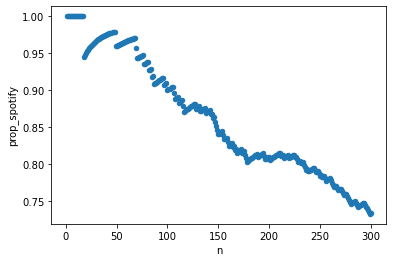

In [216]:
spotify_top.plot.scatter(x = 'n', y = 'prop_spotify')

Let's now see if we can start fitting a model.  We will ultimately have to decide if we want to include spotify playlists in this presentation, but for now we will keep them in.